<a href="https://colab.research.google.com/github/bicalabs/CogNN/blob/main/CogNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BICA model for unsupervised Hebian cognitive neural network (CogNN)

We aim to create a computationally-efficient neural network which will be able to unsupervisingly learn hidden information from the provided dataset and detect internal correlations between data such that when it will be applied to a novel data set it will be able to reveal that information.

In other words, unlike most of the existing ML models, performing supervised pattern recognition or unsupervised classification, this model will be able to explore "laws" embedded into the data and use them for "understanding" the data  (like "finding gravity law from raw data on ball drops"). This property we define as **cognition** and we plan to use biologically-inspired cognitive architecture (BICA) approach to construct such network.

We plan to build upon consepts of *spiking neuronal networks* and *unsupervised Hebian learning* (please read about them in order to unserstand what we are doing here) and use *reductionistic approach*, leaving only mathematical core of the neuronal tissue plasticcity (learning) and information processing from the typical mammals brain cortex. 

In particular, unlike most of spiking NNs, we will use synchronous modeilling of asynchronous neuronal properties. This will be done by "time discretisation", where neuronal output is defined as a number of action potencials in a *spike train*, assuming that the longest spike train still fits the single time step. This allows to represent input for each neuron as an integer number (number of received spikes in a train) and in each model time interval there will be either 0 input or positive-numbered input. The same applies to the output.

Second, no recurrency will be used, so all neurons will be organized into **neuronal layers**.

Third, we will start with the fully connected layers, assuming that sparse connections can be modelled by the weights reduced to zeros (leading that no information passage between neurons is possible).

Since we use unsupervised approach and Hebian learning, this allows us to get rid of cmputationally-expensive gradient decent back propagation, which also fits into the BICA model (thare is no gradient decent differentiation happpens in the brain cortex).

A system with all the referenced properties can be represented with a simple linear algebra model, where we operate with **neuronal layers** and not individual neuron. Each layer is defined by a **weight matrix** (two-dimensional tensor) $\mathrm{W}$ and takes a single **input vector** ($\mathbf{i}$) with the dimension equal to the number of neurons in the layer, and produce a single **output vector** ($\mathbf{o}$) of the same dimension:

$\mathbf{o} = (\mathbf{i} \times \mathrm{W})^\top$,

where $\times$ is the vector multiplication, $\mathrm{W}$ is a square matrix with $(n; n)$ dimensionality, $n$ is the number of neurons in the layer, $\mathbf{i}$ and $\mathbf{o}$ and horizontal vectors with $n$ elements and $^\top$ is the matrix transpose operation.

## Hebian learning

To define the learning rules we need to find functions which will lead to the separation of useful and non-useful inputs in the weight matrix phase space. This is done with two functions: decay and gain. The decay function $D(\mathrm{W}, \mathbf{o})$ takes outputs of the layer and weights coefficients and reduces the weights of all inputs for neurons which were not activated; the gain function $G(\mathrm{W}, \mathbf{o})$ increases the weights of all inputs if the neuron was acitve. Thus, the resulting change in layer weight matrix $\mathrm{W}$ on each taining iteration ("time" $t$) is: $\partial{\mathrm{W}}/\partial{t} = D(\mathrm{W}, \mathbf{o}) + G(\mathrm{W}, \mathbf{o})$


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

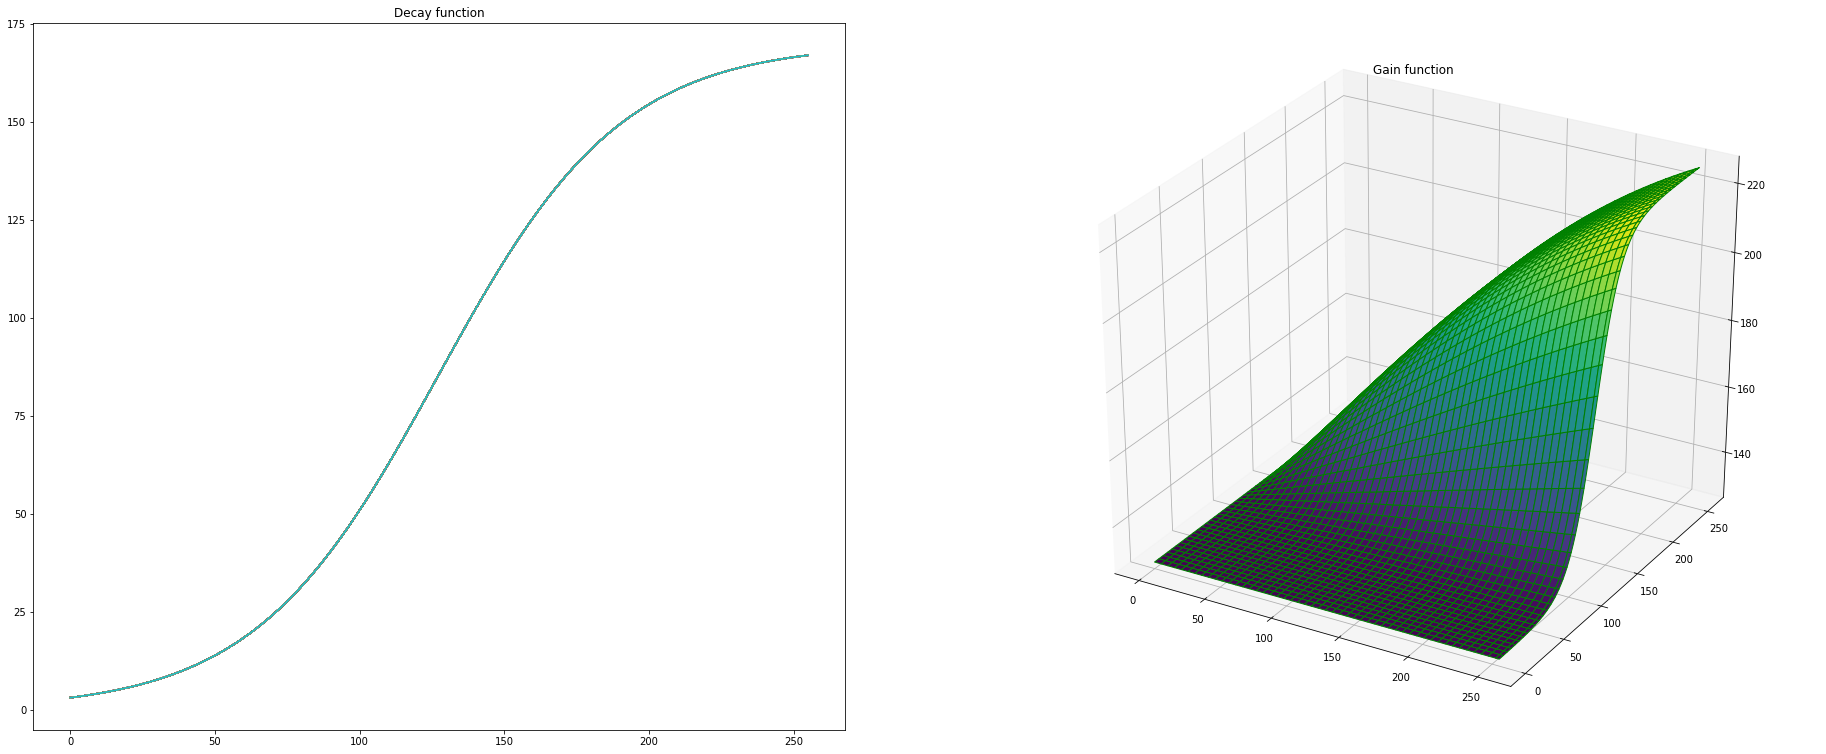

In [59]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf

def decay(input, decay_rate = 1.5, skew = 4.0):
  # output = input / (1 + 2 * tf.cos((input - 127.) / 255. * math.pi))
  # output = tf.math.log(input) / math.log(255) * 255. / decay_rate
  output = tf.sigmoid((input - 127) / 127 * skew) * 255 / decay_rate
  return output

def gain(weights, output):
  data = tf.sigmoid(weights * tf.sigmoid((output - 127) / 16) / 127) * 256
  return data

fig = plt.figure(figsize = (12, 6))

x = np.outer(np.linspace(0, 255, 100), np.ones(100))
y = decay(x)

ax = fig.add_subplot(1, 2, 1)
ax.plot(x, y)
ax.set_title('Decay function')
ax.set_xlabel('')

y = x.copy().T
z = gain(x, y)
  
# syntax for 3-D plotting
ax = fig.add_subplot(1, 2, 2, projection ='3d')
  
# syntax for plotting
ax.plot_surface(x, y, z, cmap ='viridis', edgecolor ='green')
ax.set_title('Gain function')

plt.show()

In [8]:
import tensorflow as tf
import math


class SpikingLayer(tf.Module):
  def __init__(self, dim = 256, threshold = tf.constant(10.), decay = 1.2, skew = 4., **kwargs):
    super().__init__(**kwargs)

    # Setting action potential threshold
    self.threshold = threshold
    # Setting dweights coefficient decay rate
    self.decay = decay
    self.skew = skew
    # Setting dimenstionality
    self.dim = dim

    # Initialize layers
    self.weights = tf.Variable(tf.random.uniform((dim, dim), minval = 0., maxval = 255.))
    
  def __call__(self, input, train: bool):
    input = tf.reshape(input, [1, -1])
    output = tf.clip_by_value(input @ self.weights / (255 * 255.) - self.threshold, 0., 255.)
    if train:
      output_ext = output + tf.constant(0.0, shape = (self.dim, self.dim))
      map = tf.clip_by_value(output_ext, 0, 1)
      # loss = tf.sigmoid((self.weights - 127) / 127 * self.skew) * 255 / self.decay
      # gain = (tf.sigmoid(self.weights * map) - 0.5) * 255.
      self.weights = loss(self.weights, self.decay, self.skew) * (1 - map) + gain(self.weights, output_ext) * map
    return output


class HebianNet(tf.Module):
  def __init__(self, dim = 256, layer_count = 10, threshold = tf.constant(10.), decay = 1.2, skew = 4., seed = 2613546, **kwargs):
    super().__init__(**kwargs)

    # Initialize seed for better determinism
    self.seed = seed
    tf.random.set_seed(seed)
    
    # Setting action potential threshold
    self.threshold = threshold
    # Setting dweights coefficient decay rate
    self.decay = decay
    self.skew = skew
    # Setting dimenstionality
    self.dim = dim

    self.layers = []
    self.layer_count = layer_count
    for layer_no in range(0, layer_count):
      self.layers.append(SpikingLayer(dim, threshold, decay, skew, **kwargs))

  def __call__(self, input, train: bool):
    input = tf.cast(input, tf.float32)
    for layer in self.layers:
      output = layer(input, train)
      input = output
    output = tf.reshape(output, [-1])
    return output


Now, let's define a component which will help us in visualizing the training and inference

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from keras.datasets import mnist

class Modeller:
  def __init__(self, layer_count = 5, threshold = 65., decay = 1.2, skew = 2.):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    data = tf.reshape(x_train, (-1, 28 * 28))
    self.inputs = tf.random.shuffle(data)

    self.layer_count = layer_count

    self.snn = HebianNet(
        dim = 28 * 28, 
        layer_count = layer_count, 
        threshold = threshold, 
        decay = decay, 
        skew = skew
    )

    self.display_parameters( 
        interpolation = 'nearest', 
        cmap = 'gray', 
        vmin = 0,
        vmax = 255,
        # norm = colors.BoundaryNorm(np.linspace(0, 255, 255), ncolors = 256),
    )


  def train(self, sample_size = 100):
    self.sample_size = sample_size
    self.fig1 = plt.figure(figsize = (32, 12*4))
    if self.layer_count > 1:
      self.fig2 = plt.figure(figsize = (32, 12*4))

    chart_no = 1
    self.outputs = []
    for no in range(0, sample_size):
      # Visualizing weight coefficients
      if no % (sample_size / 10) == 0:
        self.display_weights(chart_no, no)
        chart_no += 1

      output = self.snn(self.inputs[no], True)
      self.outputs.append(output)

    self.display_inout()
    return self.outputs


  def display_parameters(self, **kwargs):
    self.plot_kwargs = kwargs


  def display_weights(self, chart_no, samples):
    self.display_layer(self.fig1, chart_no, samples, 0)
    layer = self.layer_count - 1
    if layer > 0:
      self.display_layer(self.fig2, chart_no, samples, layer)

  def display_layer(self, fig, chart_no, samples, layer_no):
    weights = self.snn.layers[layer_no].weights
    ax = fig.add_subplot(4, 3, chart_no)
    img = ax.imshow(weights, **self.plot_kwargs)
    ax.set_title(f'Layer {layer_no + 1}, {samples} samples')
    ax.set_xlabel(f'min: {np.min(weights)}, max: {np.max(weights)}')
    plt.colorbar(img, ax=ax)

  def display_inout(self):
    fig = plt.figure(figsize = (32, 4))
    ax = fig.add_subplot(1, 2, 1)
    a = ax.imshow(self.inputs[:sample_size], **self.plot_kwargs)
    ax.set_title('Inputs')

    ax = fig.add_subplot(1, 2, 2)
    b = ax.imshow(self.outputs, **self.plot_kwargs)
    ax.set_title('Outputs')
    plt.colorbar(a, ax=ax)


With it we will try to run our first attempt for unsupervised learning from MNIST data:

In [ ]:
runner = Modeller(layer_count = 1)

outputs = runner.train()
weights = runner.snn.layers[0].weights

print(f'Inputs min: {np.min(runner.inputs)}, max: {np.max(runner.inputs)}')
print(f'Outputs min: {np.min(outputs)}, max: {np.max(outputs)}')
print(f'Weights min: {np.min(weights)}, max: {np.max(weights)}')
